# Исследование продаж игр компании "Стримчик"

## Цель исследования

Выявить определяющие успешность игры закономерности.

## Задача исследования

Перед нами данные до 2016 года, нужно спланировать кампанию по продаже игр на 2017-й. 

## Описание данных

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Стоит отметить, что данные за 2016 год могут быть неполными.

## 1. Изучение общей информации

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import math as mt
from tqdm.notebook import tqdm
from scipy import stats as st
import requests

sns.set_theme(style="darkgrid")
# sns.set_palette("Greys_r")
warnings.simplefilter('ignore')
tqdm.pandas()

### Добавление функций

In [2]:
# вывод количества пропущенных значений и процентное соотношение ко всем строкам dataframe
def view_null_values(data):
    return (data
         .isnull()
         .sum()
         .to_frame(name = 'count_null_values')
         .query('count_null_values != 0')
         .assign(percent = lambda x: (x['count_null_values']/len(data)))
         .sort_values(by = 'count_null_values', ascending = False)
         .style.format({'percent' : '{:.1%}'})
    )

In [3]:
# подсчет занимаемой памяти
def mem_usage(data, size = True):
    # проверим, что передаем DataFrame
    if isinstance(data, pd.DataFrame):
        usage_b = data.memory_usage(deep=True).sum()
    # иначе это Series
    else:
        usage_b = data.memory_usage(deep=True)
    # переведем в Мб
    usage_mb = usage_b / 1024 ** 2
    if size: 
        return f"{usage_mb:03.2f} MB"
    return float(f"{usage_mb:03.2f}")

In [4]:
# подсчет количества вариантов
def nCr(n, k):
    return mt.factorial(n) / (mt.factorial(k) * mt.factorial(n-k))

In [5]:
# отрисовка распределения вероятности на графике
def view_p_bar(n, p):
    distr = []

    for k in tqdm(range(0, n + 1)):
        choose = nCr(n, k)
        prob = choose * p ** k * (1 - p) ** (n - k)
        distr.append(prob)

    plt.bar(range(0,n+1), distr)
    plt.xlabel('n', fontweight='bold')
    plt.ylabel('p', fontweight='bold')
    plt.title('p(n)', fontweight='bold')

In [6]:
# проверка гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
def check_hip(data1, data2, alpha, equal_var = True):
    results = st.ttest_ind(data1, data2, equal_var=equal_var)

    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [7]:
# проверка равенства дисперсий
def equal_variance(data):
    return np.var(data, ddof=1)

### Обзор данных

In [8]:
data = ['games.csv', 'query_3.csv']
path = open('link.txt', 'r').readline()

for file in data:
    try:
        response = requests.get(path + file)
        response.raise_for_status()
    except requests.exceptions.HTTPError:
        path = '/datasets/'

df = pd.read_csv(path + data[0])

Для удобства вывода напишем вспомогательные функции:

In [9]:
def sep_text(text):
    return print(f'''
===============================================================
{text: ^64}
===============================================================
    ''')

In [10]:
def brows_data(data, name):
    data.name = name
    sep_text('DataFrame' + ': ' + name)
    display(data)
    sep_text('Info' + ': ' + name)
    display(data.info())
    sep_text('Describe' + ': ' + name)
    display(data.describe().T)
    sep_text('Dtypes' + ': ' + name)
    display(data.dtypes)

Выведем краткую информацию о данных:

In [11]:
brows_data(df, 'Games')


                        DataFrame: Games                        
    


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN



                          Info: Games                           
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None


                        Describe: Games                         
    


,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00



                         Dtypes: Games                          
    


Name                object
Platform            object
Year_of_Release    float64
Genre               object
NA_sales           float64
EU_sales           float64
JP_sales           float64
Other_sales        float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

In [12]:
view_null_values(df)

,count_null_values,percent
Critic_Score,8578,51.3%
Rating,6766,40.5%
User_Score,6701,40.1%
Year_of_Release,269,1.6%
Name,2,0.0%
Genre,2,0.0%


In [13]:
# получаем срез нужных столбцов
columns = [*df.columns[1:4], *df.columns[8:]]

for column in columns:
    print(f'unique for: {column}')
    display(df[column].unique())
    print('\n\n')

unique for: Platform


array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)




unique for: Year_of_Release


array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])




unique for: Genre


array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)




unique for: Critic_Score


array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])




unique for: User_Score


array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)




unique for: Rating


array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

### Выводы

После обзора данных, можно сделать следующие выводы:
1. Имена столбцов неплохо было бы перевести в нижний регистр,
2. В столбцах `Critic_Score, Rating, User_Score, Year_of_Release, Name, Genre` есть пропуски, где-то они около 50%, а где-то небольше 10%.
3. Столбец `Year_of_Release` нужно преобразовать к типу данных `int`, т.к. из-за пропусков он имеет тип `float`. В `User_Score` попало строковое значение `tbd`, которые ошибочно попало в выгрузку данных.

## 2. Подготовка данных

### Переименование столбцов

Преобразуем имя столбцов к строковой записи

In [14]:
df.columns = df.columns.str.lower()

In [15]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Заполнение пропусков

Вспомним, какие у нас есть пропуски:

In [16]:
view_null_values(df)

,count_null_values,percent
critic_score,8578,51.3%
rating,6766,40.5%
user_score,6701,40.1%
year_of_release,269,1.6%
name,2,0.0%
genre,2,0.0%


В столбцах `year_of_release, name, genre` удалим пропуски по следующим причинам:
1. Пропуски в `year_of_release` трудно заполнить, можно было бы попробовать вытащить год из имени игры, но это не всегда совпадает (например, LMA Manager 2007, можно подумать, что неплохо было бы ее отнести к 2007 году, но в данных, как мы видим это игра 2006 года)
2. С названием игры и жанром еще проще, это 2 одни и теже записи, нет имени - нет и жанра.

In [17]:
df.query('name != name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Удалим записи, где в столбцах `year_of_release, name, genre` есть хотя бы один пропуск

In [18]:
df = df.dropna(subset=['year_of_release', 'name', 'genre'])

Посмотрим, какие пропуски у нас еще остались:

In [19]:
view_null_values(df)

,count_null_values,percent
critic_score,8461,51.5%
rating,6676,40.6%
user_score,6605,40.2%


In [20]:
df[['critic_score', 'rating', 'user_score']].dtypes

critic_score    float64
rating           object
user_score       object
dtype: object

`critic_score` содержит больше всего пропусков (порядка 52%), посмотрим на минимальное значение столбца, в зависимости от результата выберем маркер, по которому заполним пропуски.

In [21]:
df['critic_score'].min()

13.0

Минимальное значение - 13.0, значит пропуски можно заполнить **маркером -1**.

In [22]:
df['critic_score'] = df['critic_score'].fillna(-1) 

C `rating, user_score` немного сложнее, столбцы имеют тип даннных object. 

Причем в `user_score` попало значение `tbd`, что означает `To Be Determined` - маркер пропущенного значения, который использует сама система оценивания, по сути это тот же Nan. 

Преобразуем столбец `user_rating` к числовому типу, а все значения, которые не являются числом заменим на Nan.

In [23]:
df['user_score'] = pd.to_numeric(df['user_score'], errors = 'coerce', downcast='float')

In [24]:
df['user_score'].min()

0.0

Так как у нас есть минимальная оценка 0, заполним пропущенные значения **маркером -1**.

In [25]:
df['user_score'] = df['user_score'].fillna(-1)

Пропущенные значения в столбце `rating` заполним **маркерным значением undefine** - неопределен, что будет нам говорить о том, что у данной игры был пропуск и рейтинг не установлен.

In [26]:
df['rating'] = df['rating'].fillna('undefine')

### Изменения типа данных

Приведем столбец `year_of_release` к целому числу.

In [27]:
df['year_of_release'] = df['year_of_release'].astype('int')

### Суммарные продажи во всех регионах

Добавим к нашей таблице суммарную продажу по всем регионам

In [28]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] +  df['other_sales']

### Выводы

Проделав `титаническую` работу :) по предобработке данных мы выделили такие моменты как:

1. Преобразовали имена столбцов к нижнему регистру
2. Обработали пропуски во всех столбцах и по возможности заполнили маркерным значением
3. Преобразовали к целочисленными типу данных столбец `year_of_release`
4. Пасхалка: Привет, ревьюеру!
5. Преобразовали к вещественному типу данных столбец `user_rating`
6. Посчитали суммарные продажи по всем регионам

Будем надеяться, что дальше будет так же хорошо :)



## 3. Анализ данных

### Анализ количества игр, выпущенных в разные года

Оценим количество игр, которое было выпущено в разные года.

In [29]:
def draw_bar(data, index, values, xlabel, ylabel, title, aggfunc = 'count', legend = ['Games'], double_plot = False):
    if double_plot:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(25,7), dpi=300)
        (data
            .pivot_table(index = index, values = values, aggfunc=aggfunc)
            .sort_values(by = values)
            .plot(kind = 'bar', ax = ax1)
        )
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.title.set_text(title + ': Sorted values by count games')
        ax1.legend(legend)
        (data
            .pivot_table(index = index, values = values, aggfunc=aggfunc)
            .plot(kind = 'bar', ax=ax2)
        )
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel(ylabel)
        ax2.title.set_text(title)
        ax2.legend(legend)
    else:
        (data
            .pivot_table(index = index, values = values, aggfunc=aggfunc)
            .sort_values(by = values)
            .plot(kind = 'bar', figsize=(14,7))
        )
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend(legend)
    plt.show()

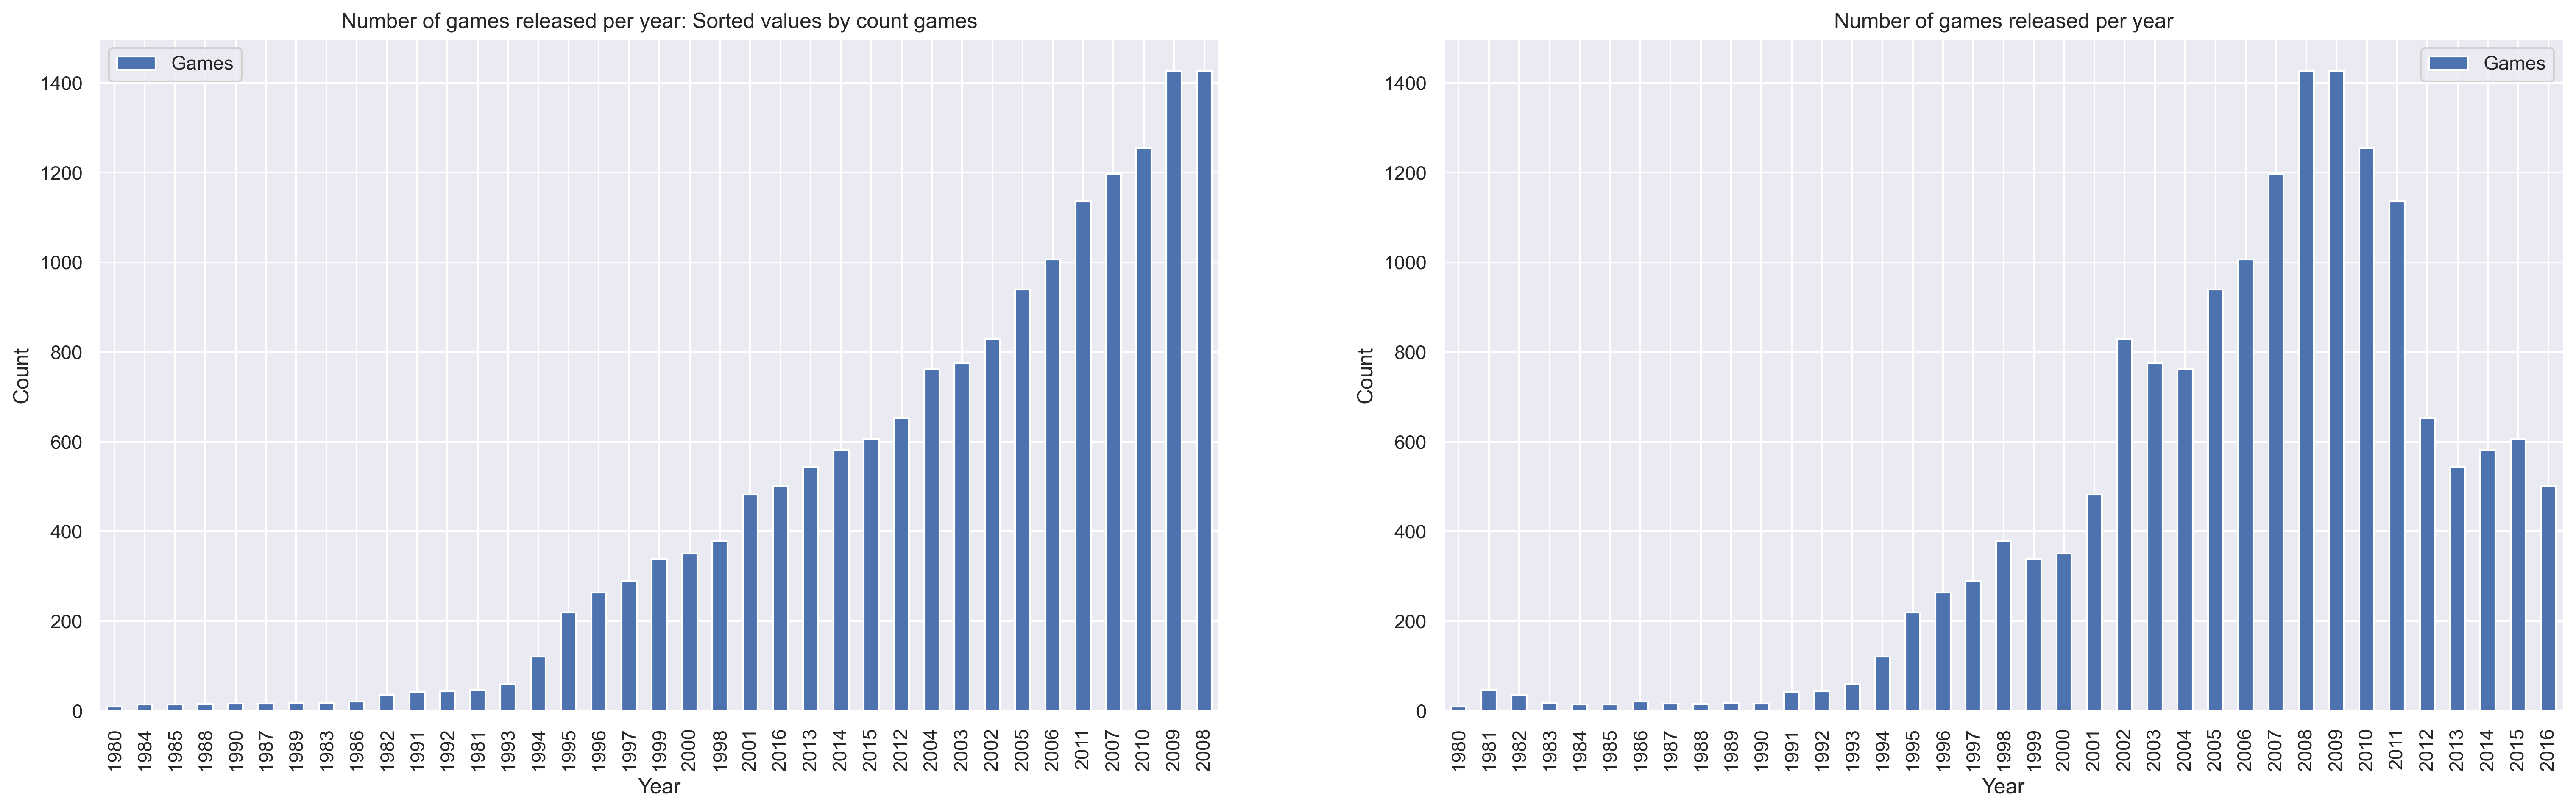

In [30]:
draw_bar(df, 'year_of_release', 'name', 'Year', 'Count', 'Number of games released per year', double_plot = True)

Как видно из графика наибольший выпуск игр пришелся на 2007-2011 года, анализ лучше производить по перспективным годам - начиная с 2013, где после спада 2012 года начинается рост продаж.


### Измерение продаж по платформам

Посмотрим, как изменялись продажи по платформам

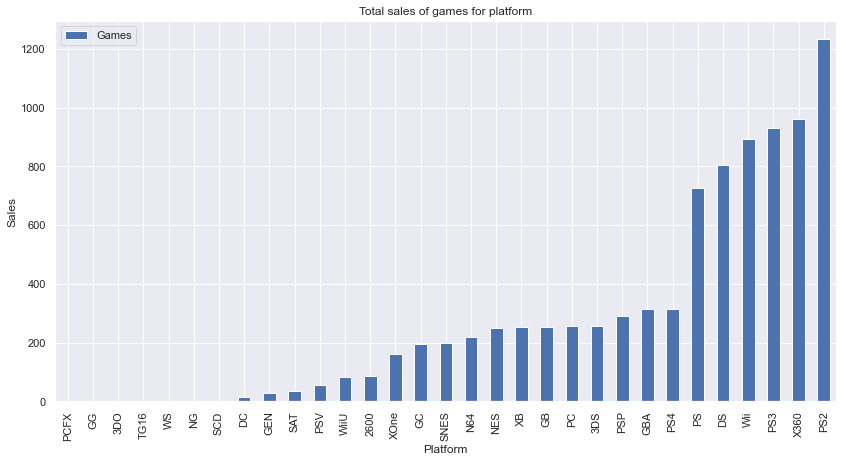

In [31]:
draw_bar(df, 'platform', 'total_sales', 'Platform', 'Sales', 'Total sales of games for platform', aggfunc = 'sum')

Сделаем ТОП-6 платформ, которые имеют самый наибольший отрыв от остальных и посмотрим по ним распределение по годам.

In [32]:
def draw_bar_for_top(data, top):
    (data
        .query("platform in @top")
        .pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc='sum')
        .plot(kind='bar', figsize=(24,7), width=1)
    )
    plt.xlabel('Year')
    plt.ylabel('Total sales, millions')
    plt.title('Time live platforms')
    plt.show()
def draw_bar_for_top_stacked(data, top):    
    (data
        .query("platform in @top")
        .pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc='sum')
        .plot(kind='bar', figsize=(24,7), stacked = True)
        
    )
    plt.xlabel('Year')
    plt.ylabel('Total sales, millions')
    plt.title('Time live platforms')
    plt.show()


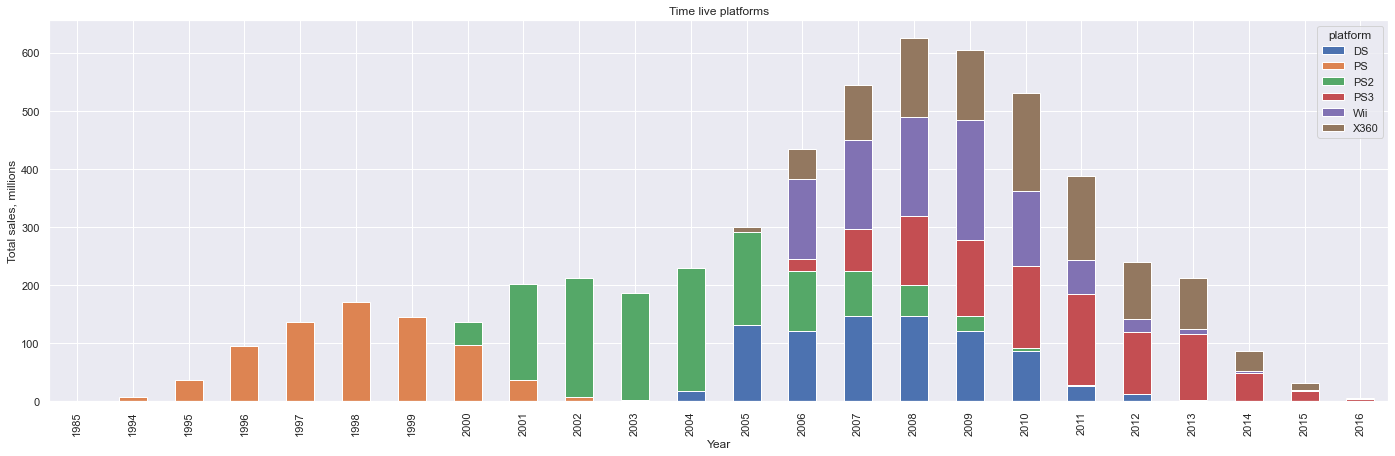

In [33]:
draw_bar_for_top_stacked(df, ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'])

Как видно из графика в среднем платформы из ТОП-6 за все время живут 8-9 лет. 
Стоит отметить, что распределение нормальное и можно предположить, что пик платформы приходится на 4-5 год после выхода на рынок.

### Данные актуального периода

Как уже было видно, платформы живут в среднем 8-9 лет, их пик приходится на 4-5 год. Учитывая это, выделим перспективные платформы на 2017 год, для этого посчитаем, у каких платформ может выпасть пик на 2017 год.

Получаем, что актуальный период для нас это 2017 - 4 = начиная с 2013 года.

Отфильтруем данные, оставив только данные начиная с 2013 года.

In [34]:
df = df.query('year_of_release >= 2013')

Посмотрим, как изменялись продажи в актуальный период

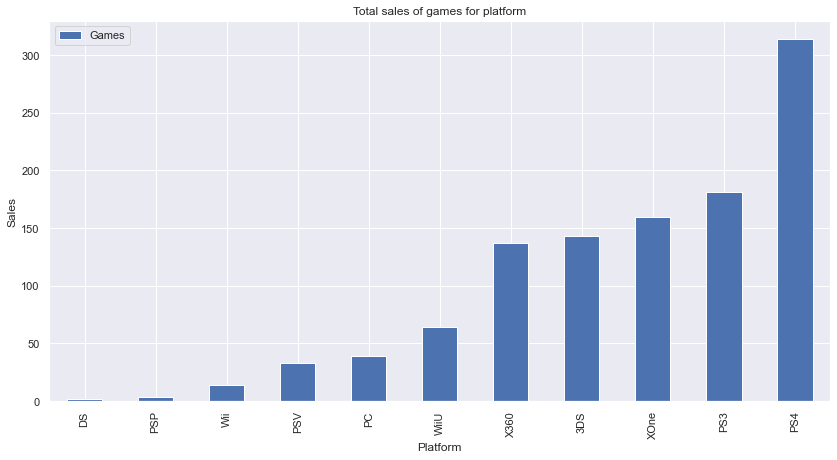

In [35]:
draw_bar(df, 'platform', 'total_sales', 'Platform', 'Sales', 'Total sales of games for platform', aggfunc = 'sum')

Выделим ТОП-7 из графика и посмотрим, как изменяются продажи за период 2013-2016 года.

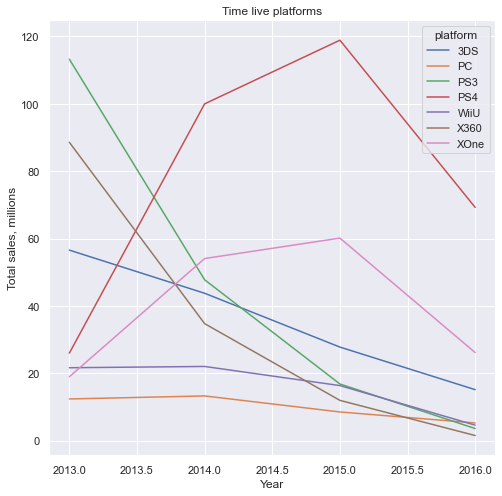

In [36]:
(df
        .query("platform in ['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC']")
        .pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc='sum')
        .plot(kind='line', figsize=(8,8))
    )
plt.xlabel('Year')
plt.ylabel('Total sales, millions')
plt.title('Time live platforms')
plt.show()

По графику можно сказать, что по продажам лидирует платформа `PS4`, на 2 и 3 месте после нее платформы `XOne, 3DS`. У всех ниспадающая тенденция, что может говорить о скором выходе новых платформ или версий, но в целом они еще являются потенциально прибыльными на следующий год.

### График "ящик с усами" по глобальным продажам игр в разбивке по платформам

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

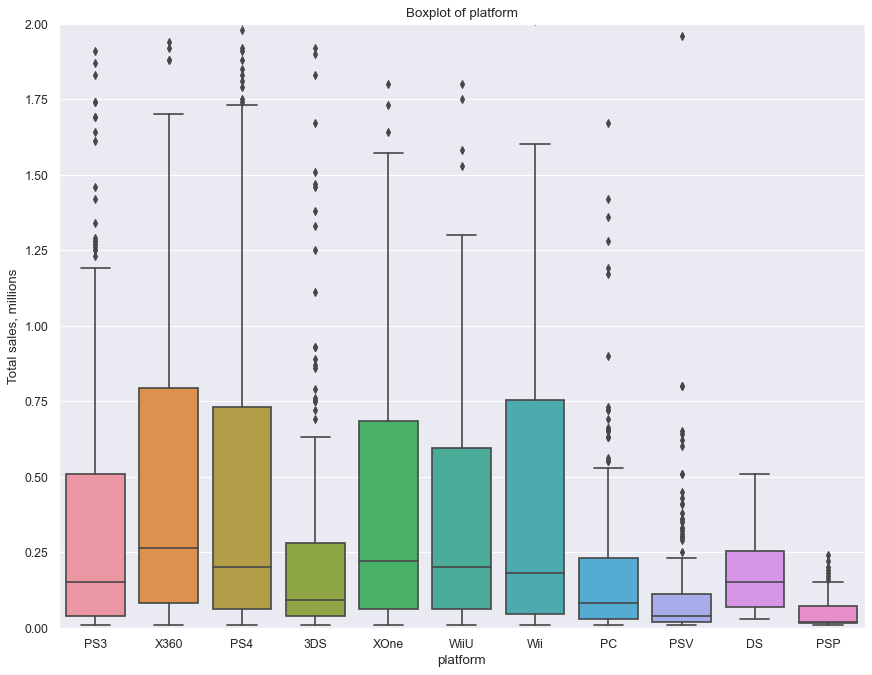

In [37]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(x = 'platform', y = 'total_sales', data = df)
plt.ylim(0,2)
plt.ylabel('Total sales, millions')
plt.title('Boxplot of platform')
plt.show()

Как можно заметить, без учетов выбросов, наибольшее медианное значение и объем продаж в пределах 75% у `X360, XOne, PS4, WiiU, Wii` - возьмем их за ТОП-5 потенциальных лидеров.

In [38]:
top5 = df.query("platform in ['X360', 'XOne', 'PS4', 'WiiU', 'Wii']")

### Влияние отзывов критиков и пользователей на продажи внутри популярных платформ

Посмотрим диаграмму рассеяния для выбранных платформ и оценим, как влиюят оценки критиков и пользователей на продажи игры.

In [39]:
def det_corr(data, column_x, column_y, _round = 3):
    return round(data[column_x].corr(data[column_y]), _round)

def draw_lmplot(data, platforms):
    for platform in platforms:
        f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
        sns.regplot(data=df.query('(critic_score > 0)  and (platform in @platform)'), x='critic_score', y='total_sales', line_kws={"color":"r","alpha":0.7,"lw":5}, ax=ax1)
        ax1.set_xlabel('critic_score, points')
        ax1.set_ylabel('total sales, millions')
        ax1.title.set_text(platform + ' critic score')
        
        sns.regplot(data=df.query('(user_score > 0)  and (platform in @platform)'), x='user_score', y='total_sales', line_kws={"color":"r","alpha":0.7,"lw":5}, ax=ax2)
        ax2.set_xlabel('user score, points')
        ax2.set_ylabel('total sales, millions')
        ax2.title.set_text(platform + ' user score')

        plt.show()
        corr_critic = df.query('(critic_score > 0)  and (platform in @platform)')
        corr_user = df.query('(user_score > 0)  and (platform in @platform)')
        print(f"Корреляция между critic_score и total_sales = {det_corr(corr_critic, 'critic_score', 'total_sales')}")
        print(f"Корреляция между user_score и total_sales = {det_corr(corr_user, 'user_score', 'total_sales')}")

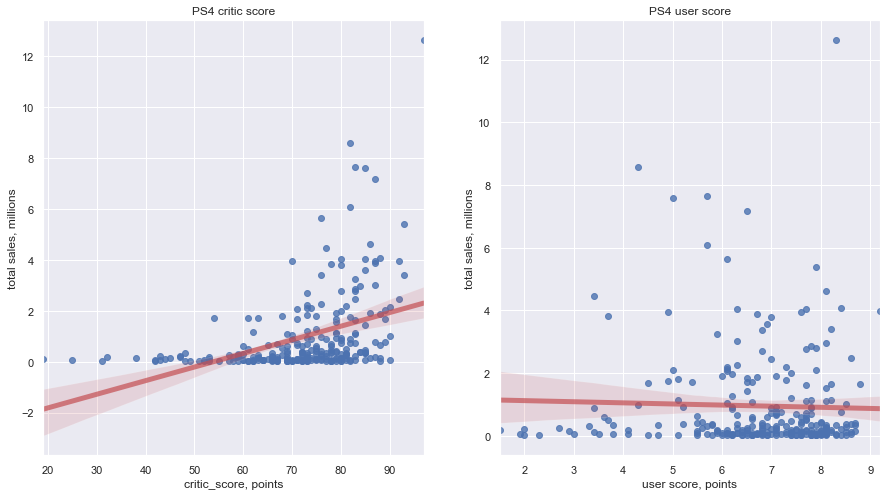

Корреляция между critic_score и total_sales = 0.407
Корреляция между user_score и total_sales = -0.032


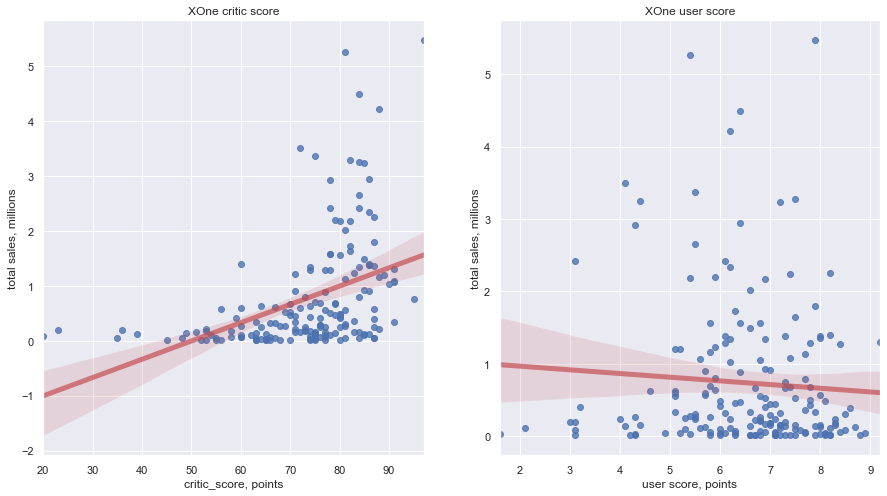

Корреляция между critic_score и total_sales = 0.417
Корреляция между user_score и total_sales = -0.069


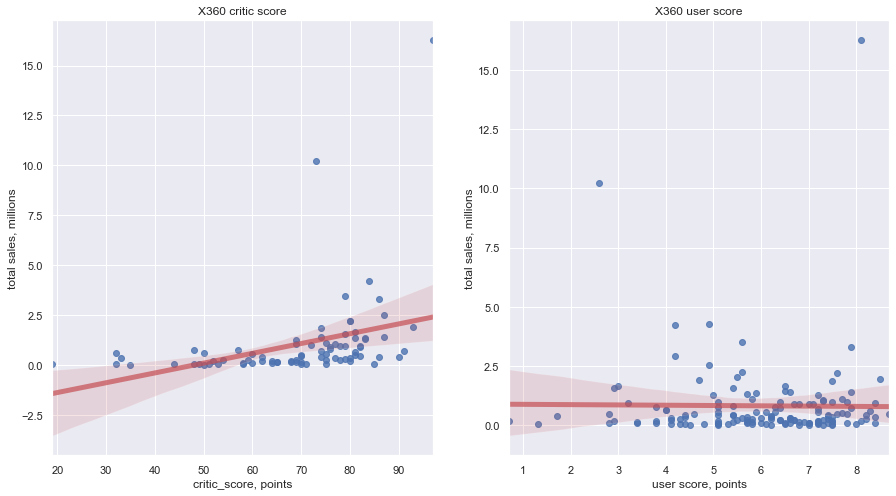

Корреляция между critic_score и total_sales = 0.35
Корреляция между user_score и total_sales = -0.012


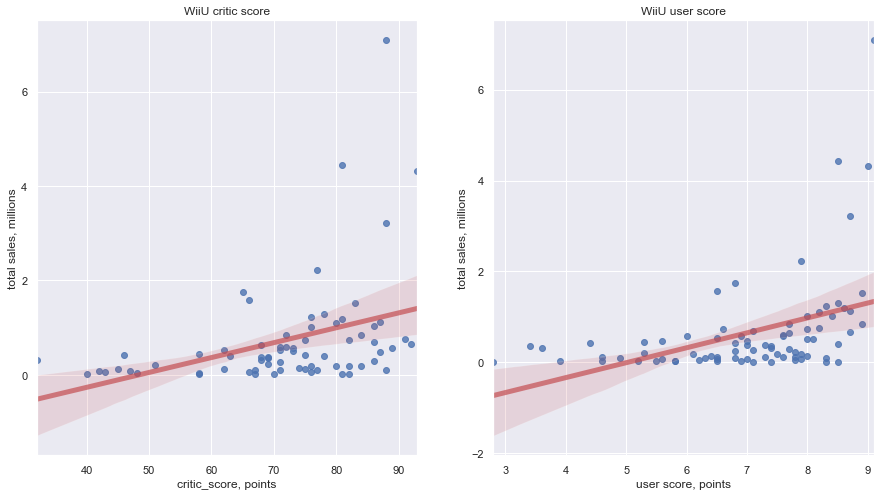

Корреляция между critic_score и total_sales = 0.376
Корреляция между user_score и total_sales = 0.419


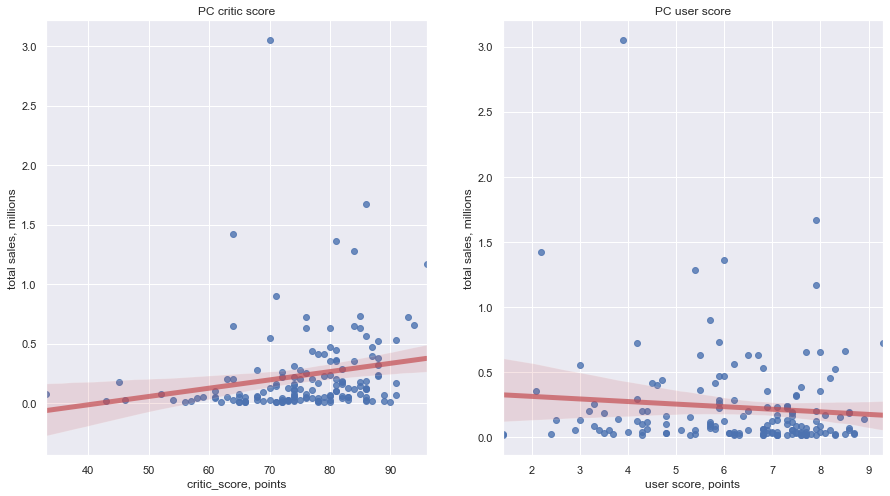

Корреляция между critic_score и total_sales = 0.196
Корреляция между user_score и total_sales = -0.094


In [40]:
draw_lmplot(df, ['PS4', 'XOne', 'X360', 'WiiU', 'PC'])

Все-таки критики - это критики, очень слабая, но положительная корреляция есть, в отличии от оценки пользователей, где корреляция около 0 или вообще отрицательная. 

Накрутку оценок никто не отменял, да и эмоции при оценке игр - лишнее, если какой-то уровень не проходится, это не повод ставить игре 2 :)

### Общее распределение игр по жанрам

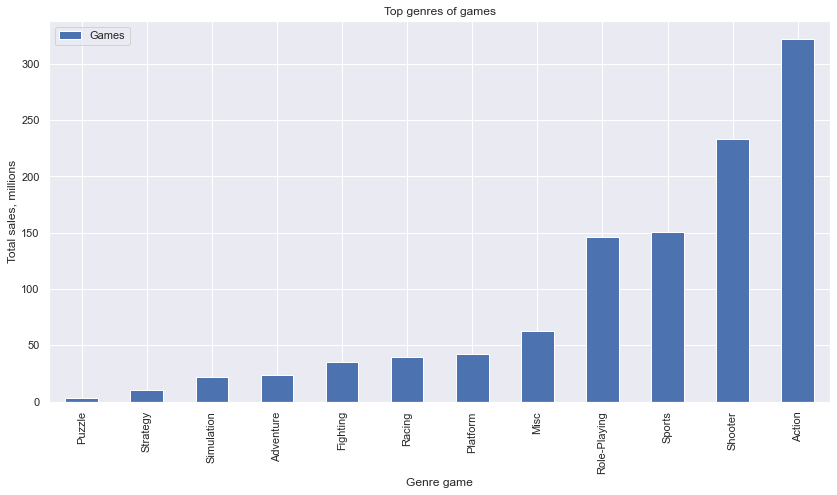

In [41]:
draw_bar(df, 'genre', 'total_sales', 'Genre game', 'Total sales, millions', 'Top genres of games', aggfunc='sum')

Судя по графику, лучше не создавать пазлы, стратегии и симуляторы, можно прогореть, а вот с RPG, Sports, Shooter, Action дела обстоят хорошо, на них большой спрос.

Эх, Heroes of Might and Magic, где же вы, надеюсь вас отнесли к RPG, а не стратегиям. :(

### Выводы

В целом, можно сказать, что:
1. Платформы живут порядка 8-9 лет, а их пик приходится как раз на 4-5 год жизни.
2. Актуальный период лучше брать начиная от 2013 года.
3. Потенциальными платформами являются ТОП-5: `PS4, X360, XOne, WiiU, Wii`

## 4. Составим портрет пользователя для каждого региона

Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы ТОП-5

In [42]:
def draw_top(data, index, values, xlabel, ylabel, title, aggfunc = 'count', legend = ['Games'], head = 10):
    (data
        .pivot_table(index = index, values = values, aggfunc=aggfunc)
        .sort_values(by = values)
        .tail(head)
        .plot(kind = 'bar', figsize=(14,7))
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(legend)
    plt.show()

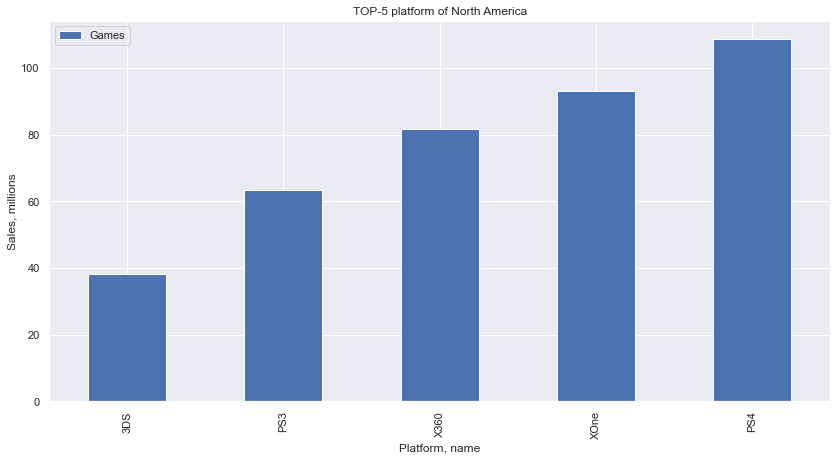

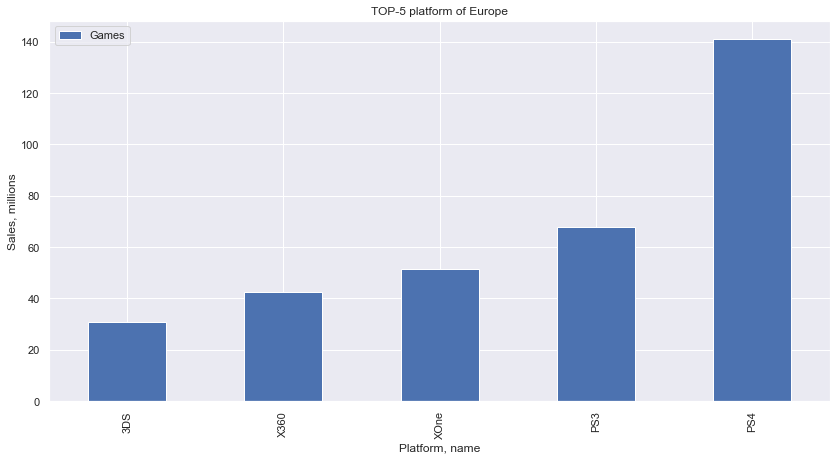

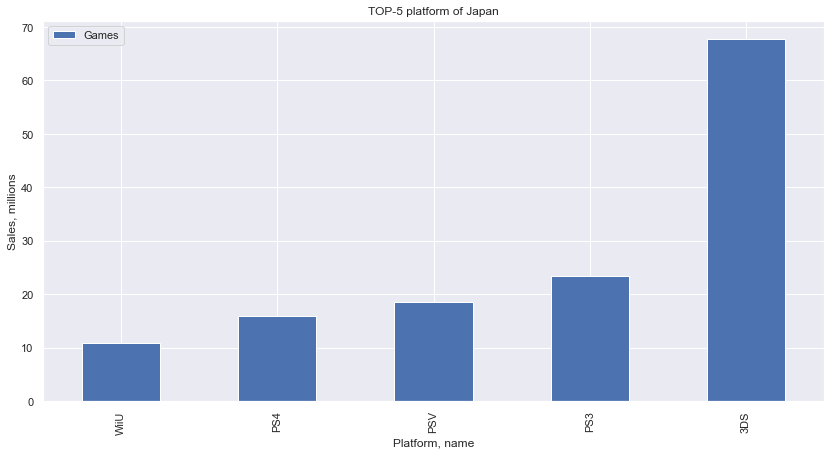

In [43]:
tmp_dict = {'na_sales':'North America', 'eu_sales':'Europe', 'jp_sales': 'Japan'}
for column, title in tmp_dict.items():
    draw_top(df, 'platform', column, 'Platform, name', 'Sales, millions', 'TOP-5 platform of ' + title, aggfunc='sum', head =5)

Можно отметить, что для регинов NA, EU - лидирует платформа PS4, когда как для JP - характерная 3DS. Это может быть связано с тем, что 3DS выпускает компания Nintendo, которая является японской компаний, специализирующейся на создании игр и игровых консолей.

### Популярные жанры ТОП-5

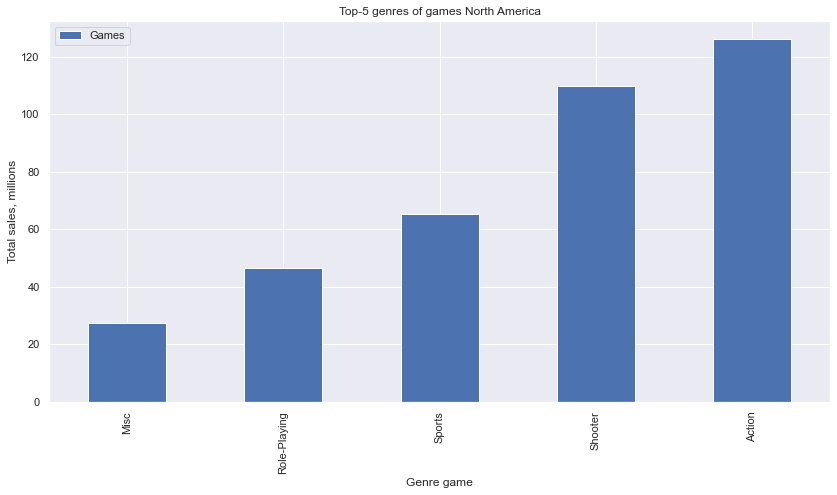

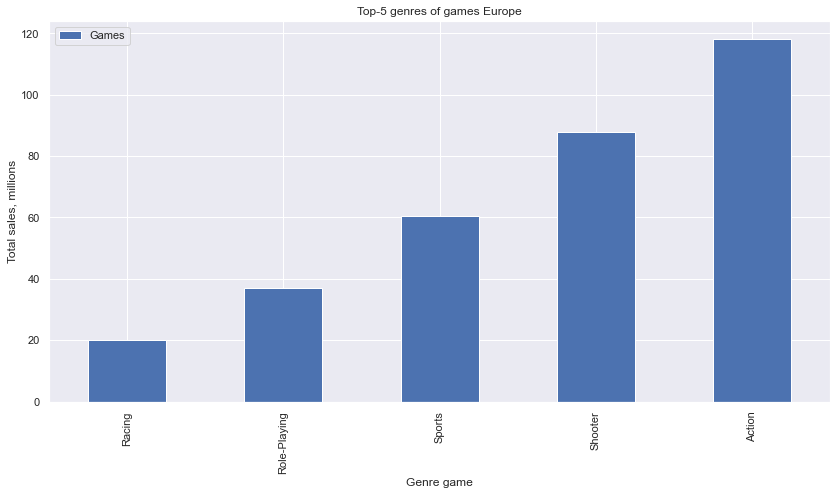

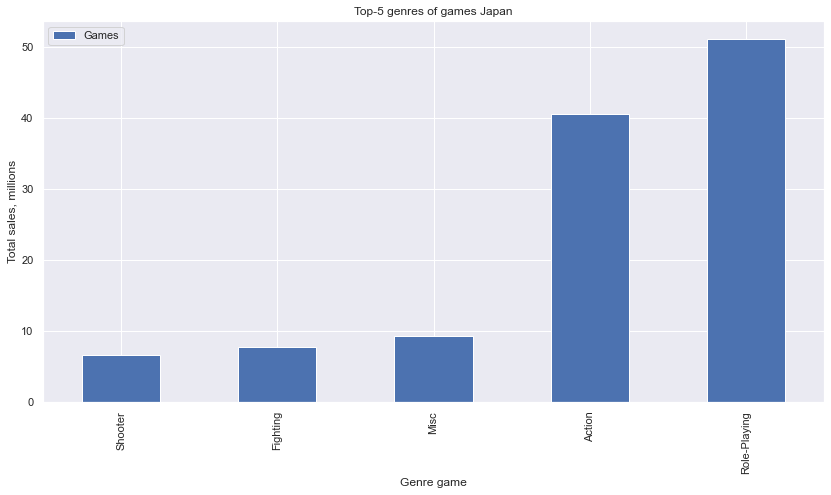

In [44]:
tmp_dict = {'na_sales':'North America', 'eu_sales':'Europe', 'jp_sales': 'Japan'}
for column, title in tmp_dict.items():
    draw_top(df, 'genre', column, 'Genre game', 'Total sales, millions', 'Top-5 genres of games ' + title, aggfunc='sum', head=5)

В регионах NA, EU - все почти идентично, а в регионе JP интереснее, там преобладает в основном жанры RPG, Action. Это может быть связано с тематикой игр для платформы 3DS, которая преобладает в этом регионе.

### Влияние рейтинга ESRB на продажи в отдельном регионе

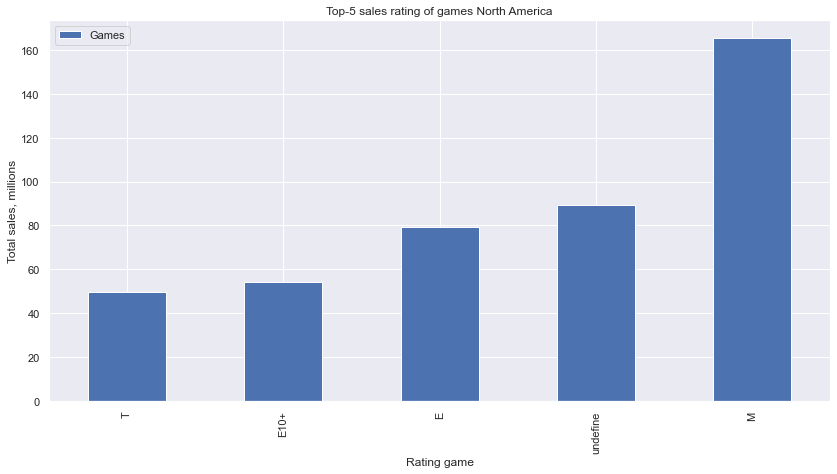

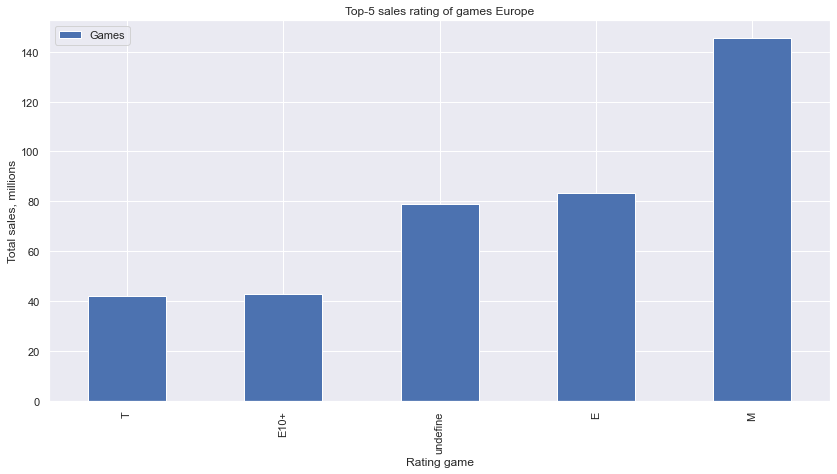

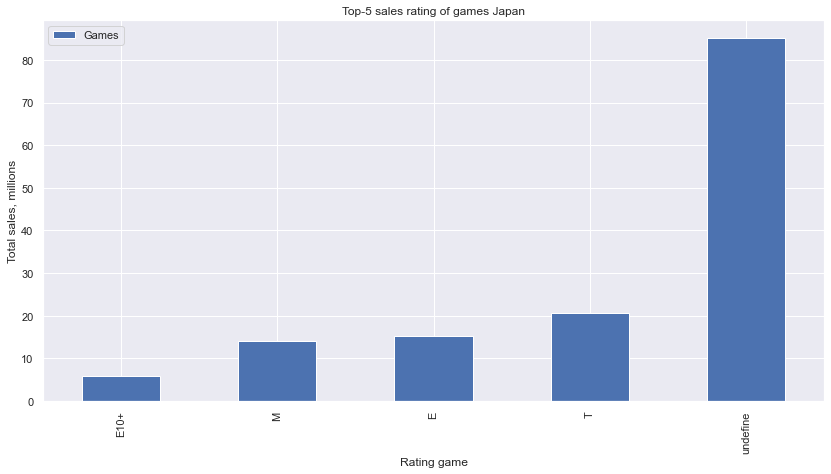

In [45]:
tmp_dict = {'na_sales':'North America', 'eu_sales':'Europe', 'jp_sales': 'Japan'}
for column, title in tmp_dict.items():
    draw_top(df, 'rating', column, 'Rating game', 'Total sales, millions', 'Top-5 sales rating of games ' + title, aggfunc='sum', head=5)

Как можно отметить, в некоторых регионах рейтинг `undefine` занимает лидирующи или преобладающие позиции, это связано с самим ESRB - негосударственной организацией, которая определяет рейтинг для игр в США и Канаде, из чего следует что игры, которые не выходят официально на территории США и Канады не получают такой рейтинг. 

### Выводы

Самыми популярными оказались жанры `Action, RPG, Shooter, Sports` - выбери один из них и не прогоришь (привет, 2020) :)

## 5. Проверка гипотез





Сформулируем Н0 и Н1 гипотезы для нашего исследования.

Гипотеза Н0 формулируется с учетом того, что средние значения в двух выборках будут равны, а гипотеза для Н1 - что различаются. 

Учитывая это, запишем:
1. Гипотеза
```
Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Н1: Средние пользовательские рейтинги платформ Xbox One и PC различаются.
```
2. Гипотеза
```
Н0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые
Н1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
```



Во всех проверках будем использовать стандартное значение `alpha = 0.05`

### Средние пользовательские рейтинги платформ Xbox One и PC

Запишем отдельно платформы XOne и PC без учета маркеров в столбце `user_score`

In [46]:
xone = df.query('(platform == "XOne") and (user_score != -1)')['user_score']
pc = df.query('(platform == "PC") and (user_score != -1)')['user_score']

Проверим выборки на нормальность

In [47]:
def test_normaltest(data, alpha = 0.05):
    stat, p = st.normaltest(data)
    print("Tests the null hypothesis that a sample comes from a normal distribution.")
    if p < alpha:
        print("Отвергаем гипотезу о нормальном распределении")
    else:
        print("Не получилось отвергнуть гипотезу о нормальном распределении")

In [48]:
test_normaltest(xone)

Tests the null hypothesis that a sample comes from a normal distribution.
Отвергаем гипотезу о нормальном распределении


In [49]:
test_normaltest(pc)

Tests the null hypothesis that a sample comes from a normal distribution.
Отвергаем гипотезу о нормальном распределении


Получаем, что наши данные не имеют нормального распределения.

Найдем дисперсии для проверки их на равенство

In [50]:
equal_variance(xone)

1.906996726989746

In [51]:
equal_variance(pc)

3.0358927249908447

Дисперсии данных выборок НЕ равны.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, воспользуемся тестом Стьюдента, т.к. он решает задачу доказательства наличия различий средних значений количественной переменной в случае, когда имеется лишь две сравниваемые группы.

Выполняя анализ, учтем также, что дисперсии **НЕ равны**, а значит параметр **equal_var** должен принимать значение **False**.

In [52]:
check_hip(xone, pc, 0.05, False)

p-значение: 0.14759702913383088
Не получилось отвергнуть нулевую гипотезу


### Средние пользовательские рейтинги жанров Action и Sports

Аналогичные рассуждения применим и для анализа пользовательских рейтингов жанров Action и Sports

In [53]:
action = df.query('(genre == "Action") and (user_score != -1)')['user_score']
sports = df.query('(genre == "Sports") and (user_score != -1)')['user_score']

Проверим выборки на нормальность



In [54]:
test_normaltest(action)

Tests the null hypothesis that a sample comes from a normal distribution.
Отвергаем гипотезу о нормальном распределении


In [55]:
test_normaltest(sports)

Tests the null hypothesis that a sample comes from a normal distribution.
Не получилось отвергнуть гипотезу о нормальном распределении


Для жанра `Sports` возникли расхождения в тестах, проверим еще одним способом - при помощи теста Д'Агостино

По результатам можно сделать вывод, что для жанра `Action` отвергаем гипотезу о нормальном распределении, когда как для жанра `Sports` не получилось отвергнуть гипотезу о нормальном распределении.

Найдем дисперсии для проверки их на равенство

In [56]:
equal_variance(action)

1.769359827041626

In [57]:
equal_variance(sports)

3.180612564086914

Дисперсии данных выборок НЕ равны.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, воспользуемся тестом Стьюдента, т.к. он решает задачу доказательства наличия различий средних значений количественной переменной в случае, когда имеется лишь две сравниваемые группы.

Выполняя анализ, учтем также, что дисперсии **НЕ равны**, а значит параметр **equal_var** должен принимать значение **False**.

In [58]:
check_hip(action, sports, 0.05, False)

p-значение: 1.445999656754529e-20
Отвергаем нулевую гипотезу


### Выводы

В ходе проверки гипотез получается, что в первом случае мы не можем отвергнуть НО гипотезу о одинаковых рейтингах платформ XOne и PC, во втором случае отвергаем гипотезу о равенстве рейтингов Action и Sports. 

## 6. Общий вывод

В результате исследования мы выяснили, что:
1. Платформы живут порядка 8-9 лет, а их пик приходится как раз на 4-5 год жизни.
2. Актуальный период для прогнозирования лучше брать начиная от 2013 года.
3. Потенциальными платформами являются ТОП-5: `PS4, X360, XOne, WiiU, Wii`
4. С популярными жанрами `RPG, Sports, Shooter, Action` дела обстоят хорошо, как в целом по регионам, так и в отдельно взятом.
5. Все-таки критики - это критики, очень слабая, но положительная корреляция есть, в отличии от оценки пользователей, где корреляция около 0 или вообще отрицательная. Накрутку оценок никто не отменял, да и эмоции при оценке игр - лишнее, если какой-то уровень не проходится, это не повод ставить игре 2 :)

В ходе проверки самих же гипотез, вспомним их:
1. Гипотеза
```
Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Н1: Средние пользовательские рейтинги платформ Xbox One и PC различаются.
```
2. Гипотеза
```
Н0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые
Н1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
```

получило, что в первом случае мы не отвергаем нулевую гипотезу, а во втором -  отвергаем нулевую гипотезу.

В заключение можно сказать, что "Стримчику" выгоднее продвигать игры жанра `RPG, Sports, Shooter, Action` для таких платформ ``PS4, X360, XOne, WiiU, Wii`.